In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential, Model
import random
import sklearn
from tensorflow.keras.regularizers import L1L2

2023-06-13 11:01:12.444214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 11:01:12.808189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-13 11:01:12.808236: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-13 11:01:12.855569: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-13 11:01:13.700553: W tensorflow/stream_executor/platform/de

False

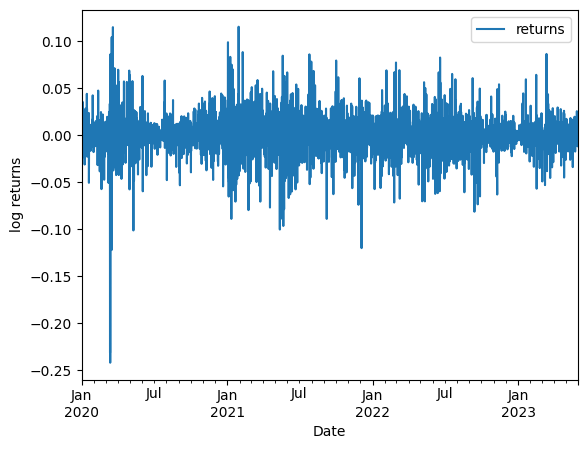

In [3]:

# Read the data from a CSV file
url = "/home/yass/code/yass2803/cryptoteller/data/BTCUSDT.csv"
df = pd.read_csv(url)
df.head()

# Change the time unit of the "open_time" column
df["open_time"] = pd.to_datetime(df["open_time"], unit='ms', origin='unix')
df = df.drop(columns=["close_time"])

df.sort_values("open_time", inplace=True)
df.loc[:, "returns"] = np.log(df.close.values / df.close.shift(1).values)# -1

# Plot the closing price over time
ax = df.plot(x='open_time', y='returns');
ax.set_xlabel("Date")
ax.set_ylabel("log returns")

# Normalization
scaler = StandardScaler()
returns = df.returns.values.reshape(-1, 1)[1:]
scaled_returns = scaler.fit_transform(returns)

scaled_returns.shape

np.isnan(scaled_returns).any()



In [4]:
# load sentinment



In [7]:
def date_to_string(date_):
    year = str(date_.year)
    month = str(date_.month)
    day = str(date_.day)
    
    if len(day) == 1:
        day = "0" + day

    if len(month) == 1:
        month = "0" + month
        
    return year + "-" + month + "-" + day

df_sentiment = pd.read_csv("/home/yass/code/yass2803/cryptoteller/data/sentiment/aggr_sent_btc.csv")

df_dates = df[["open_time"]].copy()
df_dates.loc[:,"date"] = df_dates.open_time.apply(lambda x: date_to_string(x))

df_sentiment = df_dates.merge(df_sentiment, on="date", how="left")
df_sentiment.drop(columns="date", inplace=True)
df_sentiment.head()

,open_time,sentiment
0,2020-01-01 00:00:00,1.0
1,2020-01-01 06:00:00,1.0
2,2020-01-01 12:00:00,1.0
3,2020-01-01 18:00:00,1.0
4,2020-01-02 00:00:00,1.0


In [36]:

#a=["no", "neutral", "yes"]#THIS SIMULATES THE SENTIMENT DATA, TODO: REPLACE WITH REAL SENTIMENT DATA

#sentiment = np.array(random.choices(a, k=len(df))).reshape(-1, 1)
not_nan_idx = np.where(~np.isnan(df_sentiment.sentiment.values))[0]

sentiment = df_sentiment.iloc[not_nan_idx,:].sentiment.values.reshape(-1, 1)

scaled_returns_red = scaled_returns[not_nan_idx]

OHE_encoder=sklearn.preprocessing.OneHotEncoder()
OHE_sentiment=OHE_encoder.fit_transform(sentiment).toarray()


# Preprocessing
class Preprocessor:
    def __init__(self, SEQ_LEN=120):
        self.SEQ_LEN=SEQ_LEN
        pass
    def to_sequences(self, data,sentiment, seq_len):
        d = []
        s=[]

        for index in range(len(data) - seq_len):
            d.append(data[index: index + seq_len])
            s.append(sentiment[index:index+seq_len])

        return np.array(d), np.array(s)

    def preprocess(self, data_raw,sentiment, train_split):

        data, sentiment = self.to_sequences(data_raw, sentiment, self.SEQ_LEN)

        self.num_train = int(train_split * data.shape[0])

        X_train = data[:self.num_train, :-1, :]
        y_train = data[:self.num_train, -1, :]
        sentiment_train=sentiment[:self.num_train, :-1, :]

        X_test = data[self.num_train:, :-1, :]
        y_test = data[self.num_train:, -1, :]
        sentiment_test=sentiment[self.num_train:, :-1, :]

        return X_train, y_train, X_test, y_test, sentiment_train, sentiment_test

preprocessor=Preprocessor()
(X_train, y_train, X_test, y_test,
 sentiment_train, sentiment_test) = preprocessor.preprocess(scaled_returns_red,
                                                            OHE_sentiment, 
                                                            train_split = 0.80)

print(f"sentiment train dtype: {sentiment_train.dtype}")

X_train.shape
X_test.shape

# Model

DROPOUT = 0.2
WINDOW_SIZE = preprocessor.SEQ_LEN - 1



def init_model(WINDOW_SIZE, dropout, loss, optimizer, metrics):

    inputs_price = keras.Input(shape=(WINDOW_SIZE, 1))
    inputs_sentiment = keras.Input(shape=(WINDOW_SIZE,3)) 
    hidden_lstm=LSTM(10, return_sequences=False, kernel_regularizer=L1L2(l1=0.05, l2=0.05))(inputs_price)

    concat = keras.layers.concatenate([hidden_lstm, inputs_sentiment[:, -1, :]], -1)
    hidden_final=keras.layers.Dense(32)(concat)
    output=keras.layers.Dense(1)(hidden_final)
    model = Model(inputs=[inputs_price, inputs_sentiment], outputs=output)

    #print(model.summary())
    return model




model=init_model(WINDOW_SIZE, DROPOUT, 'mean_squared_error', 'adam', ["mae"])
# Training
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

es = EarlyStopping(monitor="val_loss",
                       patience=3,
                       mode="min",
                       restore_best_weights=True)

 
model.compile(
    loss='mean_squared_error',
    metrics=["mae"] ,
    optimizer="adam"
)

BATCH_SIZE = 32



sentiment train dtype: float64


In [37]:
history = model.fit(
    [X_train, sentiment_train],
    y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/20


18/18 [==============================] - 3s 70ms/step - loss: 1.4197 - mae: 0.6330 - val_loss: 0.7369 - val_mae: 0.4005
Epoch 2/20
18/18 [==============================] - 1s 42ms/step - loss: 1.3661 - mae: 0.6254 - val_loss: 0.6901 - val_mae: 0.3919
Epoch 3/20
18/18 [==============================] - 1s 44ms/step - loss: 1.3222 - mae: 0.6220 - val_loss: 0.6494 - val_mae: 0.3866
Epoch 4/20
18/18 [==============================] - 1s 42ms/step - loss: 1.2833 - mae: 0.6203 - val_loss: 0.6118 - val_mae: 0.3840
Epoch 5/20
18/18 [==============================] - 1s 42ms/step - loss: 1.2470 - mae: 0.6193 - val_loss: 0.5773 - val_mae: 0.3824
Epoch 6/20
18/18 [==============================] - 1s 43ms/step - loss: 1.2134 - mae: 0.6186 - val_loss: 0.5453 - val_mae: 0.3817
Epoch 7/20
18/18 [==============================] - 1s 43ms/step - loss: 1.1819 - mae: 0.6180 - val_loss: 0.5153 - val_mae: 0.3813
Epoch 8/20
18/18 [==============================] - 1s 42ms/step - loss: 1.1532 - mae: 0.6175 

5/5 [==============================] - 0s 14ms/step - loss: 0.6506 - mae: 0.5586
MAE for the test set: 0.010612543271486696


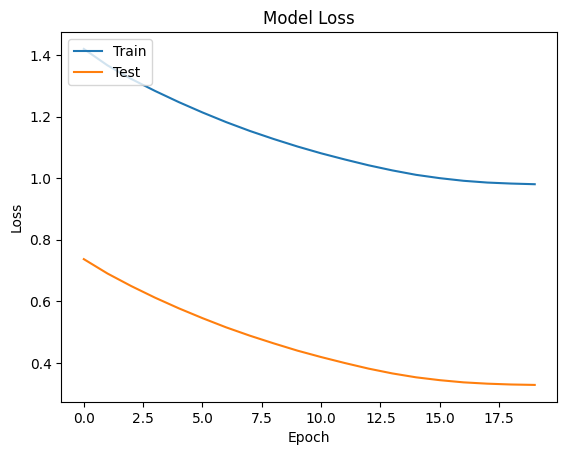

5/5 [==============================] - 0s 11ms/step


<module 'matplotlib.pyplot' from '/home/yass/.pyenv/versions/lewagon/lib/python3.10/site-packages/matplotlib/pyplot.py'>

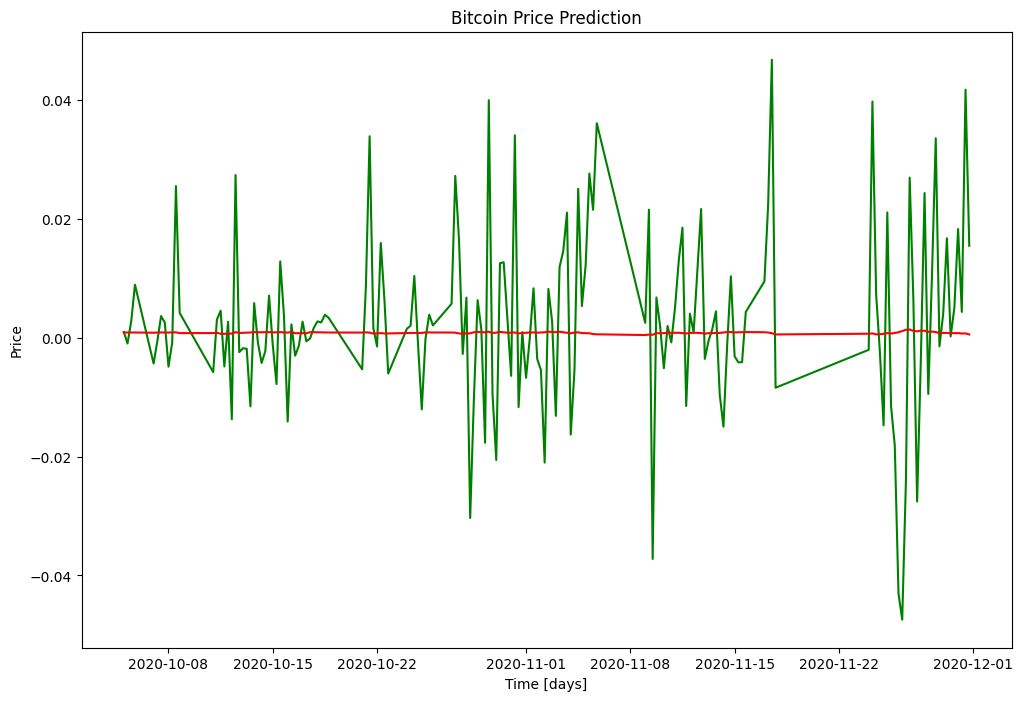

In [42]:
# Evaluation
MAE=scaler.inverse_transform([[model.evaluate([X_test, sentiment_test], y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction
y_hat = model.predict([X_test, sentiment_test])
# Inverse transform the scaled data to get the actual prices
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

# Plot the actual and predicted prices
# Prediction
date_time_test = df.iloc[not_nan_idx,:].iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt


5/5 [==============================] - 0s 15ms/step - loss: 0.6462 - mae: 0.5582
MAE for the test set: 0.010605656300146208


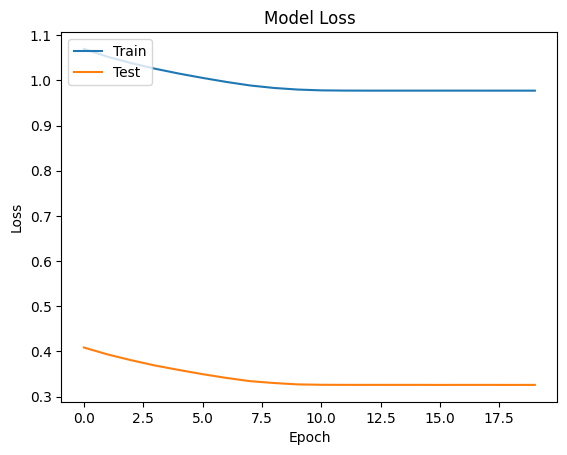

5/5 [==============================] - 0s 14ms/step
[[0.03414312]
 [0.03412999]
 [0.03410037]
 [0.03411454]
 [0.03418444]
 [0.03410716]
 [0.03408515]
 [0.03411002]
 [0.03411858]
 [0.03405248]
 [0.0340431 ]
 [0.03429304]
 [0.03427216]
 [0.0341582 ]
 [0.02341373]
 [0.02342688]
 [0.02334513]
 [0.02335768]
 [0.03395085]
 [0.03424038]
 [0.03416763]
 [0.03411947]
 [0.03408158]
 [0.03395857]
 [0.03403677]
 [0.03403203]
 [0.03399606]
 [0.03398927]
 [0.03407596]
 [0.0340604 ]
 [0.03398453]
 [0.0341289 ]
 [0.03414877]
 [0.03398827]
 [0.0232835 ]
 [0.02326106]
 [0.02326097]
 [0.02330135]
 [0.03404301]
 [0.03404629]
 [0.03406619]
 [0.0340915 ]
 [0.03410847]
 [0.03413318]
 [0.03414594]
 [0.03407013]
 [0.0341488 ]
 [0.03445394]
 [0.03436679]
 [0.03426829]
 [0.03436157]
 [0.03433447]
 [0.03419429]
 [0.0341621 ]
 [0.03414367]
 [0.0342129 ]
 [0.03415366]
 [0.03400336]
 [0.03400731]
 [0.03405215]
 [0.03407007]
 [0.03412032]
 [0.03436826]
 [0.03444871]
 [0.0343187 ]
 [0.0343104 ]
 [0.03394015]
 [0.033858

ValueError: x and y must have same first dimension, but have shapes (4223,) and (160, 1)

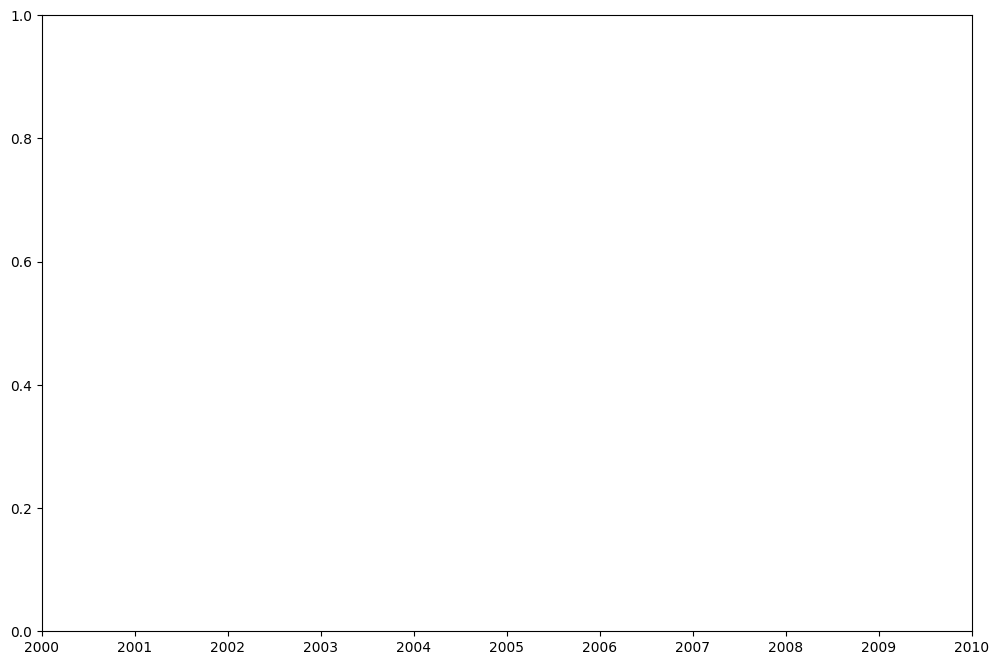

In [31]:

# Evaluation
MAE=scaler.inverse_transform([[model.evaluate([X_test, sentiment_test], y_test)[1]]])[0][0]
print(f"MAE for the test set: {MAE}")

# Plot the training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction
y_hat = model.predict([X_test, sentiment_test])
print(y_hat)
# Inverse transform the scaled data to get the actual prices
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

# Plot the actual and predicted prices
# Prediction
df_red = df.iloc[1:,:]

date_time_test = df_red.iloc[preprocessor.num_train + preprocessor.SEQ_LEN:, 0].to_numpy()

# Plot the actual and predicted prices
plt.figure(figsize=(12, 8))  # Set the figure size to make it larger
plt.plot(date_time_test, y_test_inverse, label="Actual Price", color='green')
plt.plot(date_time_test, y_hat_inverse, label="Predicted Price", color='red')

# Customize the plot
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.legend(loc='best')

plt.show()


In [ ]:
len(df)

4984

In [ ]:
a.sum()

2442

In [ ]:
a=["no", "neutral", "yes"]
import random
np.array(random.choices(a, k=len(df))).reshape(-1,1)

array([['yes'],
       ['no'],
       ['neutral'],
       ...,
       ['yes'],
       ['neutral'],
       ['no']], dtype='<U7')

In [ ]:
sentiment_test

array([[[0],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]],

       [[2],
        [2],
        [0],
        ...,
        [0],
        [0],
        [2]],

       [[2],
        [0],
        [0],
        ...,
        [0],
        [2],
        [0]],

       ...,

       [[1],
        [1],
        [2],
        ...,
        [0],
        [1],
        [2]],

       [[1],
        [2],
        [2],
        ...,
        [1],
        [2],
        [0]],

       [[2],
        [2],
        [1],
        ...,
        [2],
        [0],
        [0]]])